<a href="https://colab.research.google.com/github/YonDraco/learn-pyimagesearch/blob/master/6_video_augmented_reality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

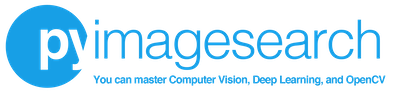

# OpenCV Video Augmented Reality

### by [PyImageSearch.com](http://www.pyimagesearch.com)

## Welcome to **[PyImageSearch Plus](http://pyimg.co/plus)** Jupyter Notebooks!

This notebook is associated with the [OpenCV Video Augmented Reality](https://www.pyimagesearch.com/2021/01/11/opencv-video-augmented-reality/) blog post published on 01-11-21.

Only the code for the blog post is here. Most codeblocks have a 1:1 relationship with what you find in the blog post with two exceptions: (1) Python classes are not separate files as they are typically organized with PyImageSearch projects, and (2) Command Line Argument parsing is replaced with an `args` dictionary that you can manipulate as needed.

We recommend that you execute (press ▶️) the code block-by-block, as-is, before adjusting parameters and `args` inputs. Once you've verified that the code is working, you are welcome to hack with it and learn from manipulating inputs, settings, and parameters. For more information on using Jupyter and Colab, please refer to these resources:

*   [Jupyter Notebook User Interface](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html#notebook-user-interface)
*   [Overview of Google Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

As a reminder, these PyImageSearch Plus Jupyter Notebooks are not for sharing; please refer to the **Copyright** directly below and **Code License Agreement** in the last cell of this notebook. 

Happy hacking!

*Adrian*

<hr>

***Copyright:*** *The contents of this Jupyter Notebook, unless otherwise indicated, are Copyright 2021 Adrian Rosebrock, PyimageSearch.com. All rights reserved. Content like this is made possible by the time invested by the authors. If you received this Jupyter Notebook and did not purchase it, please consider making future content possible joining PyImageSearch Plus at [http://pyimg.co/plus/](http://pyimg.co/plus) today.*

### Download the code zip file

In [1]:
!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/video-augmented-reality/video-augmented-reality.zip
!unzip -qq video-augmented-reality.zip
%cd video-augmented-reality

--2021-08-25 15:52:19--  https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/video-augmented-reality/video-augmented-reality.zip
Resolving pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)... 52.92.162.66
Connecting to pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)|52.92.162.66|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9716273 (9.3M) [application/zip]
Saving to: ‘video-augmented-reality.zip’

video-augmented-rea 100%[===================>]   9.27M  6.89MB/s    in 1.3s    

2021-08-25 15:52:22 (6.89 MB/s) - ‘video-augmented-reality.zip’ saved [9716273/9716273]

/content/video-augmented-reality


## Blog Post Code

### Import Packages

In [2]:
# import the necessary packages
from collections import deque
import numpy as np
import argparse
import imutils
import time
import cv2

### Implementing our marker detector/augmented reality utility function

In [3]:
# initialize our cached reference points
CACHED_REF_PTS = None

In [4]:
def find_and_warp(frame, source, cornerIDs, arucoDict, arucoParams,
	useCache=False):
	# grab a reference to our cached reference points
	global CACHED_REF_PTS

	# grab the width and height of the frame and source image,
	# respectively
	(imgH, imgW) = frame.shape[:2]
	(srcH, srcW) = source.shape[:2]

	# detect AruCo markers in the input frame
	(corners, ids, rejected) = cv2.aruco.detectMarkers(
		frame, arucoDict, parameters=arucoParams)

	# if we *did not* find our four ArUco markers, initialize an
	# empty IDs list, otherwise flatten the ID list
	ids = np.array([]) if len(corners) != 4 else ids.flatten()

	# initialize our list of reference points
	refPts = []

	# loop over the IDs of the ArUco markers in top-left, top-right,
	# bottom-right, and bottom-left order
	for i in cornerIDs:
		# grab the index of the corner with the current ID
		j = np.squeeze(np.where(ids == i))

		# if we receive an empty list instead of an integer index,
		# then we could not find the marker with the current ID
		if j.size == 0:
			continue

		# otherwise, append the corner (x, y)-coordinates to our list
		# of reference points
		corner = np.squeeze(corners[j])
		refPts.append(corner)

	# check to see if we failed to find the four ArUco markers
	if len(refPts) != 4:
		# if we are allowed to use cached reference points, fall
		# back on them
		if useCache and CACHED_REF_PTS is not None:
			refPts = CACHED_REF_PTS

		# otherwise, we cannot use the cache and/or there are no
		# previous cached reference points, so return early
		else:
			return None

	# if we are allowed to use cached reference points, then update
	# the cache with the current set
	if useCache:
		CACHED_REF_PTS = refPts

	# unpack our ArUco reference points and use the reference points
	# to define the *destination* transform matrix, making sure the
	# points are specified in top-left, top-right, bottom-right, and
	# bottom-left order
	(refPtTL, refPtTR, refPtBR, refPtBL) = refPts
	dstMat = [refPtTL[0], refPtTR[1], refPtBR[2], refPtBL[3]]
	dstMat = np.array(dstMat)

	# define the transform matrix for the *source* image in top-left,
	# top-right, bottom-right, and bottom-left order
	srcMat = np.array([[0, 0], [srcW, 0], [srcW, srcH], [0, srcH]])

	# compute the homography matrix and then warp the source image to
	# the destination based on the homography
	(H, _) = cv2.findHomography(srcMat, dstMat)
	warped = cv2.warpPerspective(source, H, (imgW, imgH))

	# construct a mask for the source image now that the perspective
	# warp has taken place (we'll need this mask to copy the source
	# image into the destination)
	mask = np.zeros((imgH, imgW), dtype="uint8")
	cv2.fillConvexPoly(mask, dstMat.astype("int32"), (255, 255, 255),
		cv2.LINE_AA)

	# this step is optional, but to give the source image a black
	# border surrounding it when applied to the source image, you
	# can apply a dilation operation
	rect = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
	mask = cv2.dilate(mask, rect, iterations=2)

	# create a three channel version of the mask by stacking it
	# depth-wise, such that we can copy the warped source image
	# into the input image
	maskScaled = mask.copy() / 255.0
	maskScaled = np.dstack([maskScaled] * 3)

	# copy the warped source image into the input image by
	# (1) multiplying the warped image and masked together,
	# (2) then multiplying the original input image with the
	# mask (giving more weight to the input where there
	# *ARE NOT* masked pixels), and (3) adding the resulting
	# multiplications together
	warpedMultiplied = cv2.multiply(warped.astype("float"),
		maskScaled)
	imageMultiplied = cv2.multiply(frame.astype(float),
		1.0 - maskScaled)
	output = cv2.add(warpedMultiplied, imageMultiplied)
	output = output.astype("uint8")

	# return the output frame to the calling function
	return output

### Creating our OpenCV video augmented reality driver script

In [5]:
# first, let's download a sample video we will use to detect ArUco markers
!wget https://colab-notebook-videos.s3-us-west-2.amazonaws.com/aruco_sample.mp4

--2021-08-25 15:52:22--  https://colab-notebook-videos.s3-us-west-2.amazonaws.com/aruco_sample.mp4
Resolving colab-notebook-videos.s3-us-west-2.amazonaws.com (colab-notebook-videos.s3-us-west-2.amazonaws.com)... 52.92.128.98
Connecting to colab-notebook-videos.s3-us-west-2.amazonaws.com (colab-notebook-videos.s3-us-west-2.amazonaws.com)|52.92.128.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10835110 (10M) [video/mp4]
Saving to: ‘aruco_sample.mp4’

aruco_sample.mp4    100%[===================>]  10.33M  7.03MB/s    in 1.5s    

2021-08-25 15:52:25 (7.03 MB/s) - ‘aruco_sample.mp4’ saved [10835110/10835110]



In [6]:
# construct the argument parser and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-i", "--input", type=str, required=True,
#	help="path to input video file for augmented reality")
#ap.add_argument("-c", "--cache", type=int, default=-1,
#	help="whether or not to use reference points cache")
#args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
    "input": "videos/jp_trailer_short.mp4",
    "cache": -1,
    "video": "aruco_sample.mp4",
    "output": "output.avi"
}

In [7]:
# load the ArUCo dictionary and grab the ArUCo parameters
print("[INFO] initializing marker detector...")
arucoDict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_ARUCO_ORIGINAL)
arucoParams = cv2.aruco.DetectorParameters_create()

# initialize the video file stream
print("[INFO] accessing video stream...")
vf = cv2.VideoCapture(args["input"])

# initialize a queue to maintain the next frame from the video stream
Q = deque(maxlen=128)

# we need to have a frame in our queue to start our augmented reality
# pipeline, so read the next frame from our video file source and add
# it to our queue
(grabbed, source) = vf.read()
Q.appendleft(source)

# initialize the video stream and initialize pointer to output
# video file
print("[INFO] starting video stream...")
vs = cv2.VideoCapture(args["video"])
writer = None

[INFO] initializing marker detector...
[INFO] accessing video stream...
[INFO] starting video stream...


In [8]:
# loop over the frames from the video stream
while len(Q) > 0:
	# grab the frame from our video stream
	frame = vs.read()[1]

    # if we did not grab a frame then we have reached the end of the
	# video
	if frame is None:
		break

    # resize the frame to have a maximum width of 600 pixels
	frame = imutils.resize(frame, width=600)

	# attempt to find the ArUCo markers in the frame, and provided
	# they are found, take the current source image and warp it onto
	# input frame using our augmented reality technique
	warped = find_and_warp(
		frame, source,
		cornerIDs=(923, 1001, 241, 1007),
		arucoDict=arucoDict,
		arucoParams=arucoParams,
		useCache=args["cache"] > 0)

	# if the warped frame is not None, then we know (1) we found the
	# four ArUCo markers and (2) the perspective warp was successfully
	# applied
	if warped is not None:
		# set the frame to the output augment reality frame and then
		# grab the next video file frame from our queue
		frame = warped
		source = Q.popleft()

	# for speed/efficiency, we can use a queue to keep the next video
	# frame queue ready for us -- the trick is to ensure the queue is
	# always (or nearly full)
	if len(Q) != Q.maxlen:
		# read the next frame from the video file stream
		(grabbed, nextFrame) = vf.read()

		# if the frame was read (meaning we are not at the end of the
		# video file stream), add the frame to our queue
		if grabbed:
			Q.append(nextFrame)

    # if the video writer is None *AND* we are supposed to write
	# the output video to disk initialize the writer
	if writer is None and args["output"] is not None:
		fourcc = cv2.VideoWriter_fourcc(*"MJPG")
		writer = cv2.VideoWriter(args["output"], fourcc, 20,
			(frame.shape[1], frame.shape[0]), True)

	# if the writer is not None, write the frame to disk
	if writer is not None:
		writer.write(frame)

# do a bit of cleanup
vs.release()
vf.release()

# check to see if the video writer point needs to be released
if writer is not None:
	writer.release()

The above code block takes a while to complete its execution. If you are interested to view the video within Colab just execute the following code blocks. Note that it may be time-consuming. 

Our output video is produced in `.avi` format. First, we need to convert it to `.mp4` format. 

In [9]:
!ffmpeg -i "output.avi" output.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [10]:
#@title Display video inline
from IPython.display import HTML
from base64 import b64encode

mp4 = open("output.mp4", "rb").read()
dataURL = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=700 controls>
      <source src="%s" type="video/mp4">
</video>
""" % dataURL)

This code is referred from [this StackOverflow thread](https://stackoverflow.com/a/57378660/7636462). 

For a detailed walkthrough of the concepts and code, be sure to refer to the full tutorial, [*OpenCV Video Augmented Reality*](https://www.pyimagesearch.com/2021/01/11/opencv-video-augmented-reality/) blog post published on 01-11-2021.

# Code License Agreement
```
Copyright (c) 2021 PyImageSearch.com

SIMPLE VERSION
Feel free to use this code for your own projects, whether they are
purely educational, for fun, or for profit. THE EXCEPTION BEING if
you are developing a course, book, or other educational product.
Under *NO CIRCUMSTANCE* may you use this code for your own paid
educational or self-promotional ventures without written consent
from Adrian Rosebrock and PyImageSearch.com.

LONGER, FORMAL VERSION
Permission is hereby granted, free of charge, to any person obtaining
a copy of this software and associated documentation files
(the "Software"), to deal in the Software without restriction,
including without limitation the rights to use, copy, modify, merge,
publish, distribute, sublicense, and/or sell copies of the Software,
and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:
The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.
Notwithstanding the foregoing, you may not use, copy, modify, merge,
publish, distribute, sublicense, create a derivative work, and/or
sell copies of the Software in any work that is designed, intended,
or marketed for pedagogical or instructional purposes related to
programming, coding, application development, or information
technology. Permission for such use, copying, modification, and
merger, publication, distribution, sub-licensing, creation of
derivative works, or sale is expressly withheld.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS
BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN
ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```